## Homework: Problem 1

a) Implement a PD based trajectory-tracking controller for the robot.

b) Use the controller to track the end-effector trajectories defined by the function 'trajectory(t)' which is implemented in this file. 

c) Provide plots comparing the desired and actual values to show the tracking performance of the controller. Show plots for the joint angles and the end-effector co-ordinates.

In [41]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

import time

In [42]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(math.radians(theta1))+l2*math.cos(math.radians(theta1)+math.radians(theta2))
    y = l1*math.sin(math.radians(theta1))+l2*math.sin(math.radians(theta1)+math.radians(theta2))
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [43]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.DIRECT) # or p.GUI


# Load the URDF of the plane that forms the ground
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = p.loadURDF("plane.urdf")


# Load the URDF of the robot
robot = p.loadURDF("planar_2R_robot.urdf")

In [44]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
p.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [45]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
p.setJointMotorControl2(robot, 1, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 2, p.VELOCITY_CONTROL, force=0)


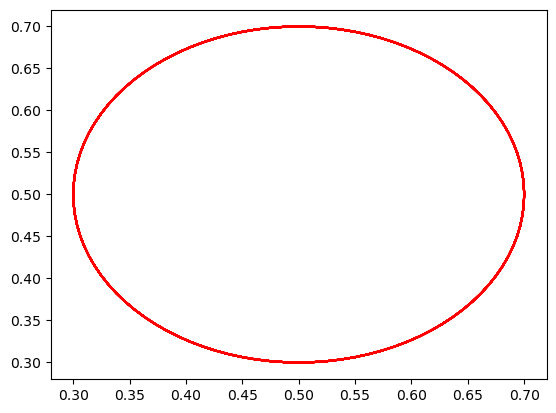

In [46]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory(t):
    '''
    A function to specify the trajectory
    Args:
    t: time
    Returns:
    x: X coordinate of the end-effector
    y: Y coordinate of the end-effector
    '''
    
    r = 0.2
    omega = 2*np.pi*2
    
    # Centre of trajectory
    [x0, y0] = [0.5, 0.5]
    
    x = x0 + r*np.cos(omega*t)
    y = y0 + r*np.sin(omega*t)
    
    return x, y

# Plot the trajectory
x_plt = []; y_plt = [];
for t in np.arange(0, 5, 0.005):
    x, y = trajectory(t)
    x_plt.append(x)
    y_plt.append(y)
    
        


plt.plot(x_plt, y_plt, 'red')
 
plt.show()


In [47]:
#since we're employing two different controllers for the two joints, maybe we can explore separate gain values for the two controllers
kp1=3800 #proportional gain
kd1=1300  #derivative gain
bias1=0

kp2=3000 #proportional gain
kd2=600  #derivative gain
bias2=0

#lengths of links
l1=0.5
l2=0.5

In [48]:
##########################################
# Control loop to follow the trajectory
##########################################

# WRITE YOUR CODE HERE #
p.resetJointState(robot,1,0)
p.resetJointState(robot,2,0)

dt=0.005 #time interval
max_time=5

x_error_prior=0
y_error_prior=0

theta1_error_prior=0
theta2_error_prior=0

theta1_measured_plt=[]; theta2_measured_plt=[];
theta1_desired_plt=[]; theta2_desired_plt=[];

x_desired_plt=[]; y_desired_plt=[];
x_measured_plt=[]; y_measured_plt=[];


for t in np.arange (0, max_time, dt):
    theta1_measured, _, _, _ = p.getJointState(robot, 1)
    theta2_measured, _, _, _ = p.getJointState(robot, 2)
    theta2_measured=theta2_measured-theta1_measured

    theta1_measured_plt.append(theta1_measured)
    theta2_measured_plt.append(theta2_measured)

    [x_measured, y_measured] = forward_kinematics(theta1_measured, theta2_measured, l1, l2)
    x_measured_plt.append(x_measured)
    y_measured_plt.append(y_measured)
    #print(x_measured, y_measured)

    x_t, y_t=trajectory(t)

    #we can use forward kinematics to calculate x and y desired as well but no need since we get desired values from trajectory function
    x_desired=x_t
    y_desired=y_t

    x_desired_plt.append(x_desired)
    y_desired_plt.append(y_desired)

    valid, [theta1_desired, theta2_desired] = inverse_kinematics(x_t, y_t, l1, l2)
    #[x_desired, y_desired] = forward_kinematics(theta1_desired, theta2_desired, l1, l2)

    theta1_desired_plt.append(theta1_desired)
    theta2_desired_plt.append(theta2_desired)

    theta1_error=theta1_desired-theta1_measured
    theta2_error=theta2_desired-theta2_measured

    theta1_derivative=(theta1_error-theta1_error_prior)/dt
    theta2_derivative=(theta2_error-theta2_error_prior)/dt

    theta1_error_prior=theta1_error
    theta2_error_prior=theta2_error

    torque_joint1=theta1_error*kp1 + theta1_derivative*kd1 +bias1
    torque_joint2=theta2_error*kp2 + theta2_derivative*kd2 +bias2

    p.setJointMotorControl2(robot, 1, p.TORQUE_CONTROL, force=torque_joint1)
    p.setJointMotorControl2(robot, 2, p.TORQUE_CONTROL, force=torque_joint2)
    p.stepSimulation()

    #the following was an attempt to make a controller based on x and y rather than theta1 and theta1

    # x_error=x_desired-x_measured
    # y_error=y_desired-y_measured

    # x_derivative=(x_error-x_error_prior)/dt
    # y_derivative=(y_error-theta2_error_prior)/dt

    # x_error_prior=x_error
    # y_error_prior=y_error

    # valid, [theta1_error, theta2_error] = inverse_kinematics(x_error, y_error, l1, l2)
    # valid, [theta1_derivative, theta2_derivative] = inverse_kinematics(x_derivative, y_derivative, l1, l2)


    # torque_joint1=theta1_error*kp + theta1_derivative*kd +bias
    # torque_joint2=theta2_error*kp + theta2_derivative*kd +bias


    
    # print(p.getJointState(robot, 1))
    # print(p.getJointState(robot, 2))

    # print(torque_joint1)
    # print(torque_joint2)
 

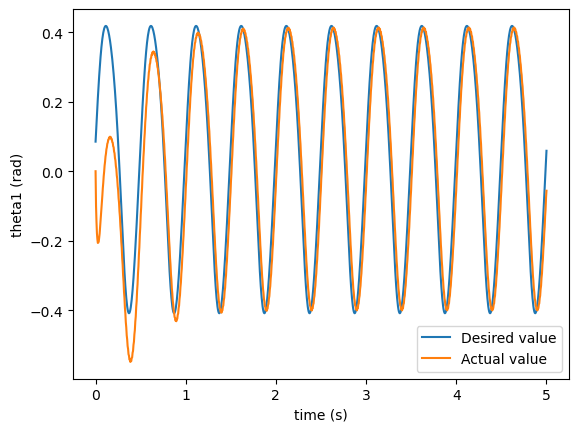

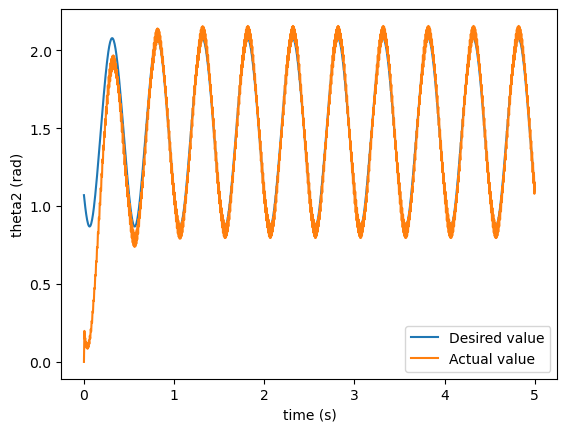

In [49]:
##########################################
# Plot the data in joint-space
##########################################

# WRITE YOUR CODE HERE #
x=np.linspace(0, max_time, num=len(theta1_desired_plt))
plt.plot(x, theta1_desired_plt, label="Desired value")
plt.plot(x, theta1_measured_plt, label="Actual value")

plt.xlabel("time (s)")
plt.ylabel("theta1 (rad)")

plt.legend() 
plt.show()

plt.plot(x, theta2_desired_plt, label="Desired value")
plt.plot(x, theta2_measured_plt, label="Actual value")

plt.xlabel("time (s)")
plt.ylabel("theta2 (rad)")

plt.legend() 
plt.show()





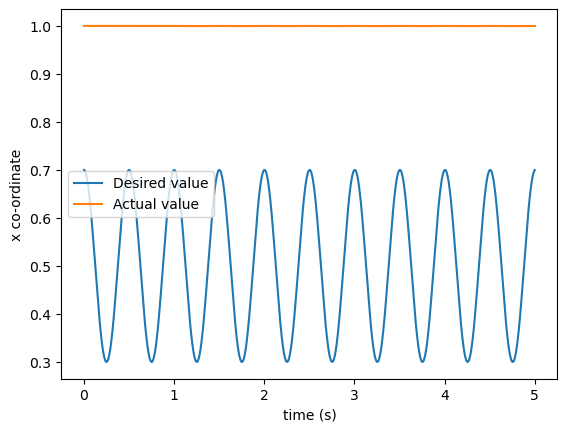

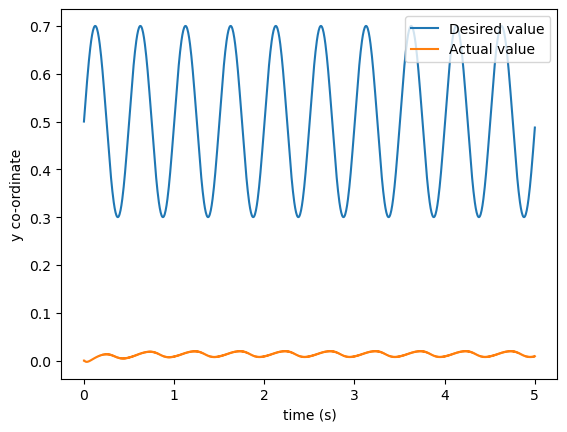

In [50]:
##########################################
# Plot the data in task-space
##########################################

# WRITE YOUR CODE HERE #
plt.plot(x, x_desired_plt, label="Desired value")
plt.plot(x, x_measured_plt, label="Actual value")

plt.xlabel("time (s)")
plt.ylabel("x co-ordinate")

plt.legend() 
plt.show()

plt.plot(x, y_desired_plt, label="Desired value")
plt.plot(x, y_measured_plt, label="Actual value")

plt.xlabel("time (s)")
plt.ylabel("y co-ordinate")

plt.legend() 
plt.show()

